In [42]:
import tensorflow as tf
from carrim import PhysicalModel, RIM
from carrim.models import CNN, Model, MixtureDensityNetwork
import os
import json
from argparse import Namespace
import corner
import scipy.stats
from tqdm import tqdm
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
from tqdm import tqdm

plt.style.use("science")
params = {'legend.fontsize': 'x-large',
#           'figure.figsize': (10, 10),
         'axes.labelsize': 25,
         'axes.titlesize':25,
         'xtick.labelsize':25,
         'ytick.labelsize':25}
pylab.rcParams.update(params)

In [2]:
# model trained previous to 220429 were trained with arctan(e2, e1)/2 transform on angle. Their learned prior is [0, pi/2] which is a problem.
model = os.path.join("../models/CNN_g1_043_lr0.0001_dr0.9_inceptionV3_220429122436")


with open(model + "/cnn_model_hparams.json", "r") as f:
    hparams = json.load(f)
with open(model + "/script_params.json", "r") as f:
    args = json.load(f)
args = Namespace(**args)

cnn = CNN(**hparams)
ckpt = tf.train.Checkpoint(step=tf.Variable(1), net=cnn)
checkpoint_manager = tf.train.CheckpointManager(ckpt, model, max_to_keep=1)
checkpoint_manager.checkpoint.restore(checkpoint_manager.latest_checkpoint).expect_partial()

phys = PhysicalModel(
        pixels=args.pixels,
        image_fov=args.image_fov,
        src_fov=args.src_fov,
        psf_cutout_size=args.psf_cutout_size,
        r_ein_min=args.r_ein_min,
        r_ein_max=args.r_ein_max,
        n_min=args.n_min,
        n_max=args.n_max,
        r_eff_min=args.r_eff_min,
        r_eff_max=args.r_eff_max,
        max_gamma=args.max_gamma,
        max_ellipticity=args.max_ellipticity,
        max_lens_shift=args.max_lens_shift,
        max_source_shift=args.max_source_shift,
        noise_rms_min=args.noise_rms_min,
        noise_rms_max=args.noise_rms_max,
        noise_rms_mean=args.noise_rms_mean,
        noise_rms_std=args.noise_rms_std,
        psf_fwhm_min=args.psf_fwhm_min,
        psf_fwhm_max=args.psf_fwhm_max,
        psf_fwhm_std=args.psf_fwhm_std,
        psf_fwhm_mean=args.psf_fwhm_mean,
        sersic_i_eff=100
)

# Prepare a dataset

In [24]:
N = 10000
B = 10

true = []
pred = []

for batch in tqdm(range(N//B)):
    obs, params, noise_rms, psf_fwhm = phys.draw_sersic_batch(B)
    true.append(params.numpy())
    pred.append(phys.model_to_physical(cnn(obs).numpy()))
true = np.concatenate(true, axis=0)
pred = np.concatenate(pred, axis=0)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [04:08<00:00,  4.02it/s]


# Train MDN

In [ ]:
mdn = MixtureDensityNetwork(input_shape=13, units=128, layers=2, k=1)

In [31]:
optimizer = tf.keras.optimizers.Adam(lr=1e-4)
loss = lambda y, model: -model.log_prob(y)

mdn.compile(optimizer, loss=loss)
mdn.fit(
    x = pred,
    y = true,
    epochs=100,
    batch_size=200,
    verbose=0
)

/home/alexandre/anaconda3/envs/carrim/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


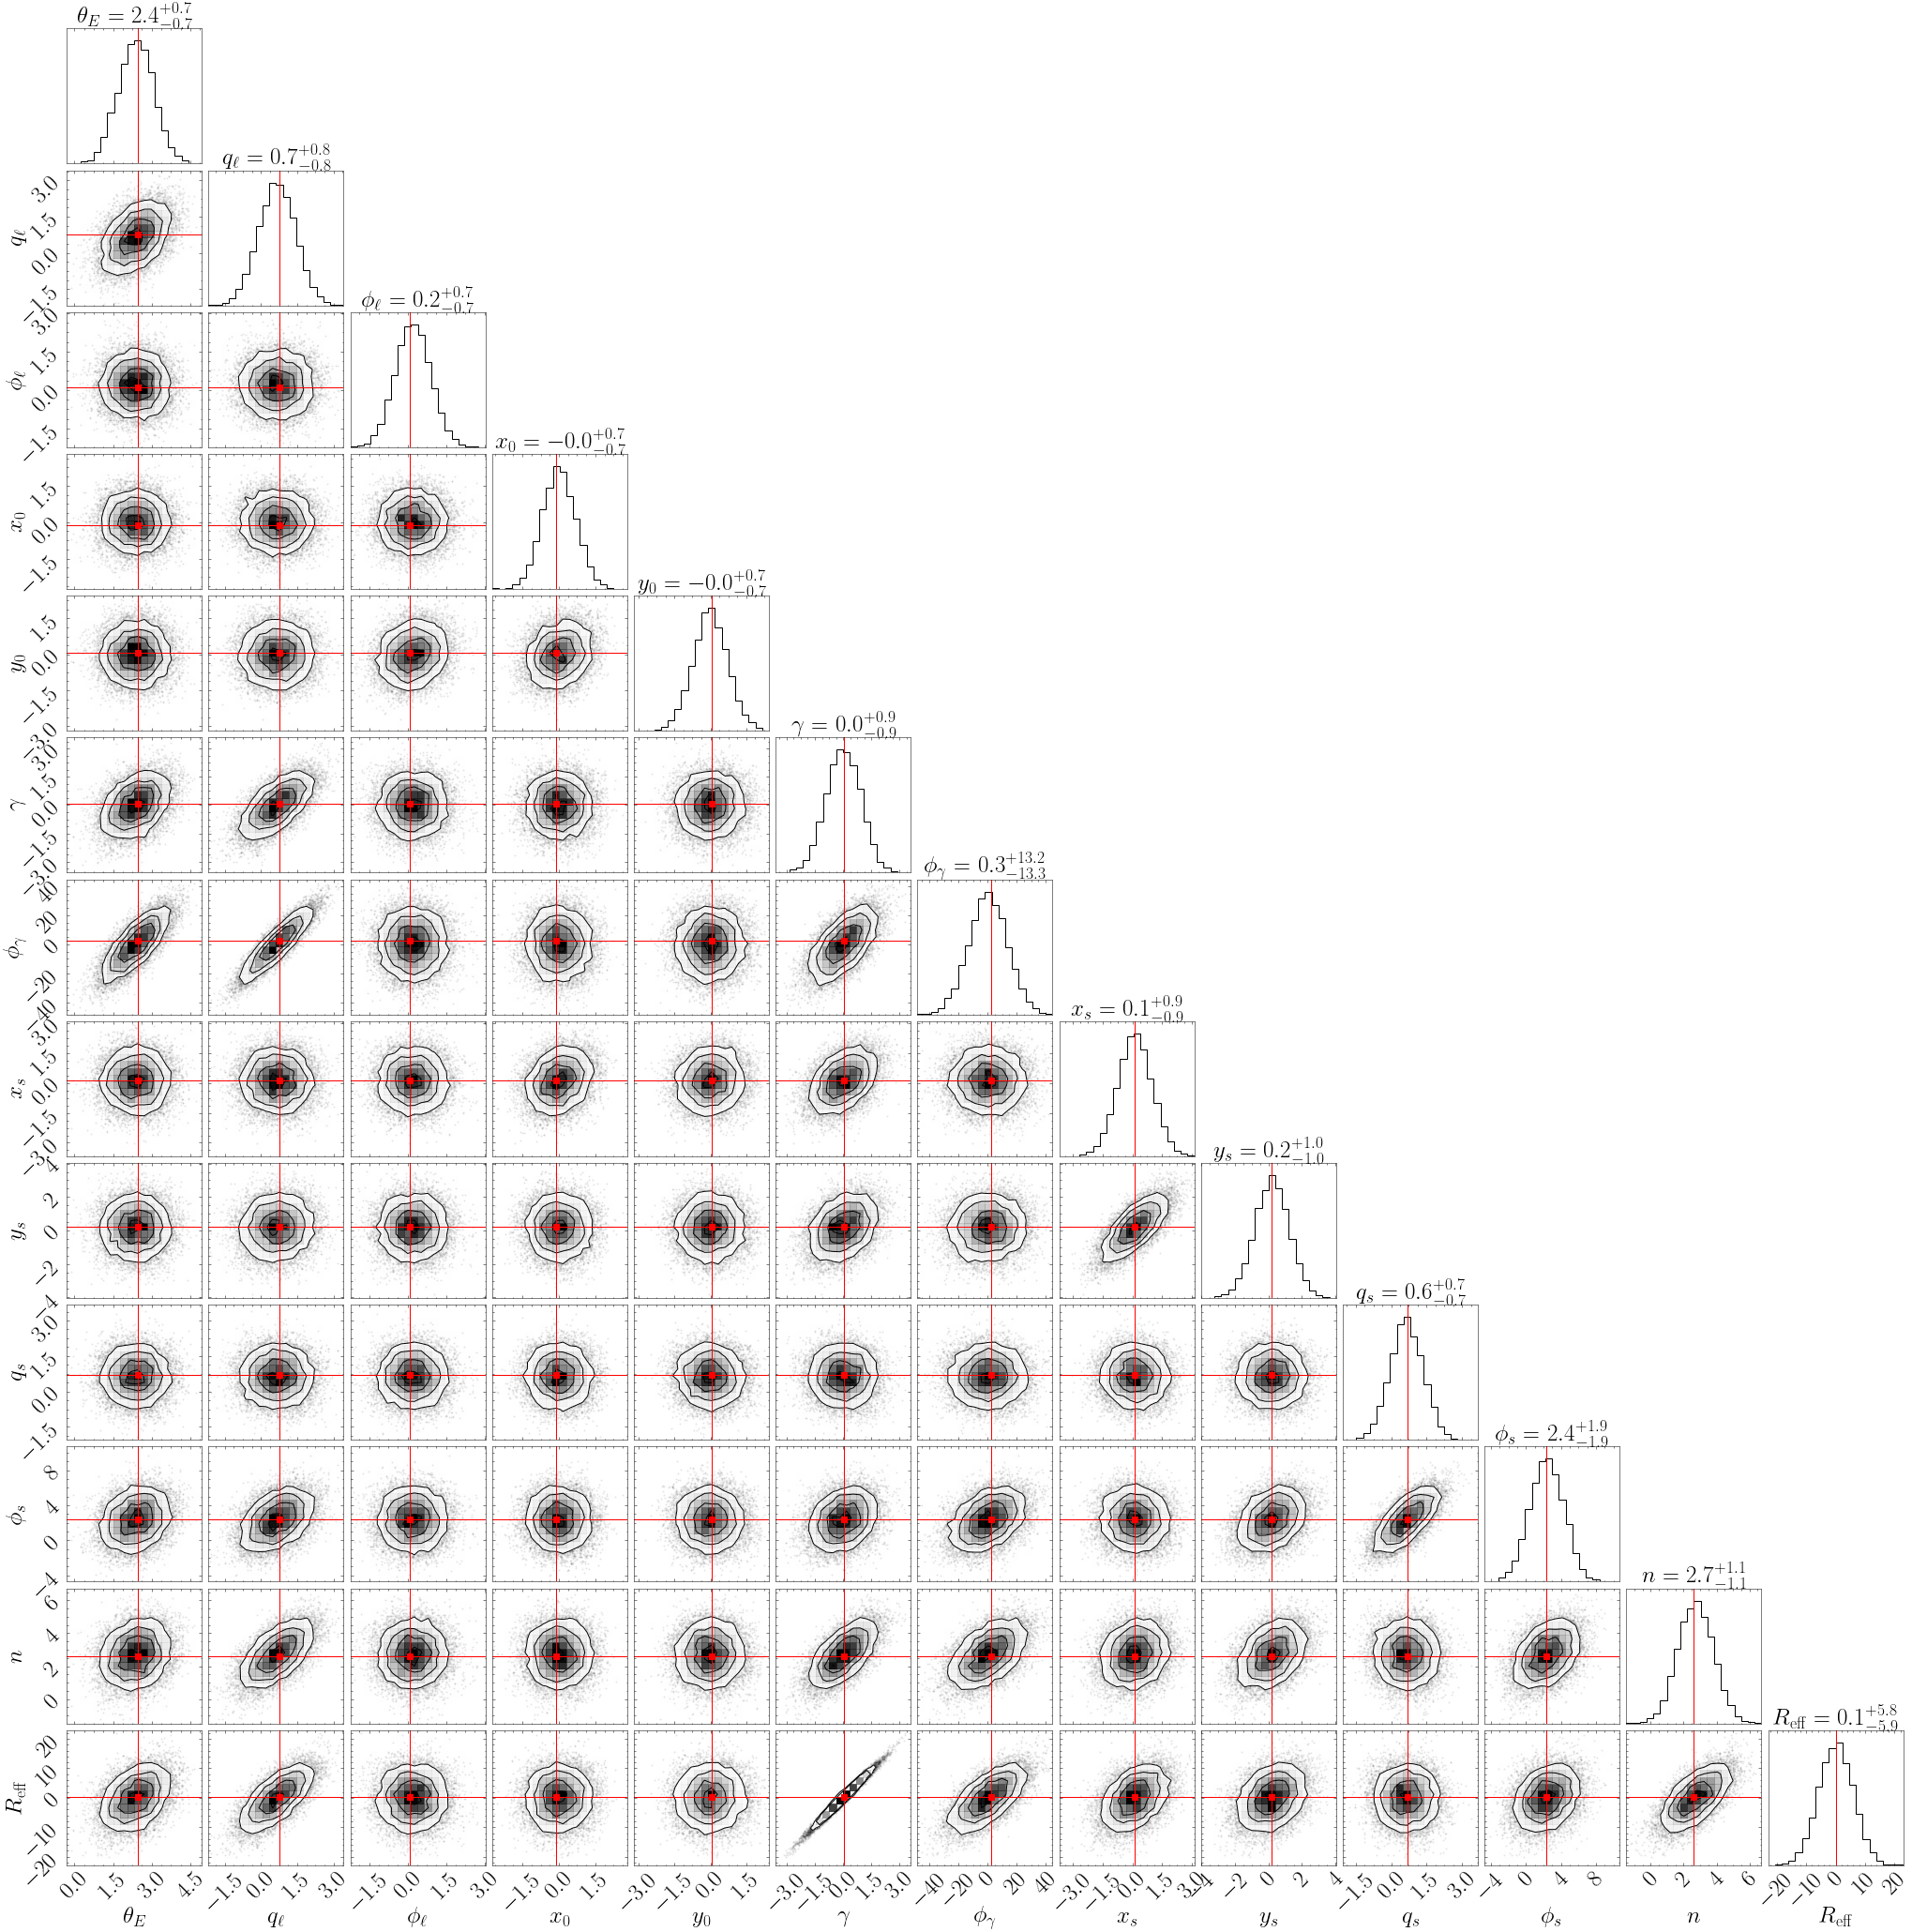

In [32]:
samples = mdn.sample(pred[0, :][None], 10000).numpy()[:, 0, :]
labels = [r"$\theta_E$", r"$q_\ell$", r"$\phi_\ell$", r"$x_0$", r"$y_0$", r"$\gamma$", r"$\phi_\gamma$", r"$x_s$", r"$y_s$", r"$q_s$", r"$\phi_s$", r"$n$", r"$R_{\mathrm{eff}}$"]
figure = corner.corner(samples, labels=labels, show_titles=True, title_fmt=".1f", truths=true[0, :], truth_color="r")

# Empirical Coverage Test

## Empirical expected coverage probability
Given our posterior estimator, how many times does the ground truth fall under the confidence interval given a confidence probability $1 - \alpha$?

In [110]:
mdn.call(pred).cdf # need to implement this!

<bound method Distribution.cdf of <tfp.distributions._TensorCoercible 'tensor_coercible' batch_shape=[10000] event_shape=[13] dtype=float32>>